In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

In [ ]:
def clear_layers(viewer):
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

# Generate random XY, ZX, and ZY slices from a training dataset

In [ ]:
import numpy as np
from numpy.random import randint
from tifffile import imread, imwrite
from tqdm import tqdm
import os

def get_rand_slices(im: np.ndarray, samples = 3):
    ''' 
    Returns a dictionary of random XY, XZ, and YZ slices from a 3D stack.
    Parameters: im - a 3D stack
                samples - the number of slices for each dimension to return
    Returns:    a dictionary of slices labeled with their dimension and index
    '''
    assert im.ndim == 3, 'Image must be 3D'
    d = {}
    z,y,x = im.shape
    for n in range(samples):
        randyx = randint(0,z)
        randzx = randint(0,y)
        randzy = randint(0,x)
        d[f"randyx_{randyx}_#{n}"]=im[randyx]
        d[f"randzx_{randzx}_#{n}"]=im[:,randzx]
        d[f"randzy_{randzy}_#{n}"]=im[:,:,randzy]
    return d

source = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
dest = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2_random_slices'
if not os.path.exists(dest):
    os.mkdir(dest)
names = [f for f in os.listdir(source) if f.endswith('_16bit_scaleZ_sbdl2_16bit.tif') and not f.startswith('.')]
for name in tqdm(names):
    im = imread(source +'/'+name)
    justname = name.split('.')[0]
    slices = get_rand_slices(im, samples = 3)
    for k,v in slices.items():
        imwrite(f'{dest}/{justname}_{k}.tif',v)

# Augment dataset by artificially turning xy slices into xz slices by adding 1D Gaussian Blur

#### Example of synthetic training data

In [ ]:
og_path = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2/220710_Fix_Em_Flvw_Mix_PI_aTub647_E02-Z01_PI_16bit_randyx_164_#1.tif'
og = imread(og_path)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(og, 7, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(og, cmap='gray', vmin = 0, vmax=15000)
ax2.imshow(gauss, cmap='gray', vmin = 0, vmax=15000)

get rid of the log processed files, and existing ortho projections

In [ ]:
target_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V3/new_gauss/'

# make a list of files with "log" in the name
delete_list = [f for f in os.listdir(target_dir) if 'log' in f or 'zx' in f or 'zy' in f]
# delete the files
for f in delete_list:
    os.remove(os.path.join(target_dir, f))

ims = [f for f in os.listdir(target_dir) if f.endswith('tif') and 'yx' in f and not f.startswith('.')]

Gaussian blur the images

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

with tqdm(total = len(ims)) as pbar:
    for im in ims:
        im_path = os.path.join(target_dir, im)
        im_data = imread(im_path)
        im_data = ndimage.gaussian_filter1d(im_data, 7.5, 0)
        imwrite(im_path, im_data)
        pbar.update(1)

Rename in the images and .npy files

In [ ]:
tifs = [f for f in os.listdir(target_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(target_dir) if f.endswith('.npy') and not f.startswith('.')]

for f in tifs:
    base = f.split('.')[0]
    newname = base + '_gauss.tif'
    os.rename(os.path.join(target_dir, f), os.path.join(target_dir, newname))

for s in segs:
    base = s.split('_seg.npy')[0]
    newname = base + '_gauss_seg.npy'
    os.rename(os.path.join(target_dir, s), os.path.join(target_dir, newname))

# Convert .npy files to labels and save as tif files

This is necessary for training cellpose in GDrive

In [ ]:
from tifffile import imwrite
import numpy as np
from tqdm import tqdm
import shutil
import os

# dir containing ...tif and ..._seg.npy files
raw_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2' 
tifs = [f for f in os.listdir(raw_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(raw_dir) if f.endswith('.npy') and not f.startswith('.')]

# create save directories
base_save_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2_GD'
image_save_dir = os.path.join(base_save_dir, 'Images')
mask_save_dir = os.path.join(base_save_dir, 'Masks')
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)

# copy all tifs to the image save dir
for f in tifs:
    shutil.copy(os.path.join(raw_dir, f), image_save_dir)

# extract the masks out of each of the seg files and save as tif to the mask save dir
with tqdm(total=len(segs)) as pbar:
    for s in segs:
        item = np.load(os.path.join(raw_dir, s), allow_pickle=True).item()
        masks = item['masks']
        save_name = s.split('_seg.npy')[0] + '.tif'
        imwrite(os.path.join(mask_save_dir, save_name), masks)
        pbar.update(1)

Convert a single npy file into masks

In [ ]:
from tifffile import imwrite
import numpy as np
import os

# dir containing ...tif and ..._seg.npy files
dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit_seg.npy' 

# create save directories
item = np.load(os.path.join(dir, name), allow_pickle=True).item()
masks = item['masks']
save_name = name.split('_seg.npy')[0] + '_Masks_Fused.tif'
imwrite(os.path.join(dir, save_name), masks, imagej=True, metadata={'axes': 'ZYX'})

# Batch process volumes with DoG filters

In [ ]:
import os
from tqdm import tqdm
from skimage import filters
from tifffile import imread, imwrite

processing_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ'
save_dir = os.path.join(processing_dir, 'sbdl2_processed')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

im_names = [f for f in os.listdir(processing_dir) if f.endswith('.tif') and not f.startswith('.')]

with tqdm(total=len(im_names)) as pbar:
    for im_name in im_names:
        im_base = im_name.split('.')[0]
        im = imread(os.path.join(processing_dir, im_name))
        sbdl2 = filters.difference_of_gaussians(im, low_sigma=2, high_sigma=128)
        # save as 32 bit float
        imwrite(os.path.join(save_dir, f'{im_base}_sbdl2.tif'), sbdl2.astype('float32'), imagej=True, metadata={'axes': 'ZYX'})
        pbar.update(1)

# remove a label and re-save

In [ ]:
from tifffile import imread, imwrite
import numpy as np
import os

base = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/U-Net_3D/' 
name = '220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_Crop_46-98_Target.tif' 
masks = imread(os.path.join(base, name))
base_name = name.split('.')[0]
masks[masks == 63] = 0
imwrite(os.path.join(base, base_name + '_corr.tif'), masks, imagej=True, metadata={'axes': 'ZYX'})


# Turn instance segmentation into semantic segmentation

#### Example:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
import matplotlib.pyplot as plt

dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training/Target'
sem_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E10-Z01_PI_16bit_scaleZ_crop_40-61_crop_Target.tif' 
sem = imread(os.path.join(dir, sem_name))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sem[15], cmap='Set3')

# iterate through all of the labels in sem, and erode them
labels = np.unique(sem)
binary = np.zeros(sem.shape)

for label in labels:
    if label == 0:
        continue
    else:
        mask = sem == label
        mask = ndimage.binary_erosion(mask, iterations = 2)
        binary[mask] = 1

ax2.imshow(binary[15], cmap='Set3')

#### Batch processing:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_binary_8bit_3'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

for mask_name in tqdm(mask_names):
    sem = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(sem)
    binary = np.zeros(sem.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = sem == label
            mask = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# turn instance into multiclass semantic segmentation

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

# source dirs and names
base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

# dest dirs and names
save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_multiclass_8bit_1'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

# make the changes. background pixels are set to 0, edges are 1, cytoplasm is 2
for mask_name in tqdm(mask_names):
    instance_labels = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(instance_labels)
    binary = np.zeros(instance_labels.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = instance_labels == label
            eroded = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
            binary[eroded] = 2
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# Convert file to 8-bit

In [ ]:
from tifffile import imread, imwrite
import os
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_Binary_8bit' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

for mask_name in tqdm(mask_names):
    mask = imread(os.path.join(mask_dir, mask_name))
    imwrite(os.path.join(mask_dir, mask_name), mask.astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_dir, source_name), source[1:-1].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})

# Elastic deform

In [ ]:
import os
import numpy as np
import napari
import raster_geometry as rg
import tifffile as tif
%gui qt 

In [ ]:
viewer = napari.Viewer()

In [ ]:
import elasticdeform

clear_layers(viewer)
sphere = rg.sphere(125,40)
ints = np.zeros(sphere.shape, dtype=int)
ints[sphere] = 1
print(np.unique(ints))
viewer.add_image(sphere, name='sphere', blending='additive', colormap='green')
deformed = elasticdeform.deform_random_grid(ints, sigma=0.005, points=30)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='red')
print(np.unique(deformed))

In [ ]:
from skimage.draw import line_aa
from skimage.draw import line_nd
from tqdm import tqdm

clear_layers(viewer)

object_num = 500

ROI_size = 500

start_x = np.random.randint(0,ROI_size)
end_x = np.random.randint(0, ROI_size)

start_y = np.random.randint(0,ROI_size)
end_y = np.random.randint(0, ROI_size)

start_z =  np.random.randint(0, ROI_size)
end_z =  np.random.randint(0, ROI_size)

canvas_vol = np.zeros((ROI_size, ROI_size, ROI_size))

for t in tqdm(range(object_num)):
    indice = [np.random.randint(0, ROI_size) for i in range(6)]
    
    start_pt, end_pt = indice[:3], indice[3:]
    
    line_pts = line_nd(start_pt, end_pt) 

    for i in range(len(line_pts[0])):
        canvas_vol[line_pts[0][i], line_pts[1][i], line_pts[2][i]] = 1#(2**16-1)*(2/3)  

viewer.add_image(canvas_vol, name='canvas', blending='additive', colormap='magenta')
deformed = elasticdeform.deform_random_grid(canvas_vol, sigma=3, points=70)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='green')
print(np.unique(canvas_vol))
print(np.unique(deformed))

# Filtering low quality segmentations:

In [1]:
import os
import numpy as np
import napari
from tifffile import imread, imwrite
from skimage import morphology
from tqdm import tqdm
from skimage.filters import threshold_multiotsu
import time
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import filters
from skimage.morphology import label
from skimage.morphology import binary_erosion
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from scipy import spatial
import vg # vector-geometry and linear-algebra toolbelt

In [2]:
%gui qt 
viewer = napari.Viewer()

/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


#### Read the data and define useful functions:

In [13]:
base_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2' 
masks_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit_Masks_Fused.tif'
tub_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_Tub_16bit_scaleZ_sbdl2_16bit.tif' 
pi_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit.tif'

masks = imread(os.path.join(base_dir, masks_name))#[::4,::4,::4]
tub = imread(os.path.join(base_dir, tub_name))#[::4,::4,::4]
pi = imread(os.path.join(base_dir, pi_name))#[::4,::4,::4]

def wipe_layers():
    '''
    Delete all layers in the viewer objected
    '''
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

def remove_large_objects(labels_array: np.ndarray, max_size: int) -> np.ndarray:
    ''' 
    Remove all objects in a mask above a specific threshold
    '''
    out = np.copy(labels_array)
    component_sizes = np.bincount(labels_array.ravel()) # count the number of pixels in different labels
    too_big = component_sizes > max_size
    too_big_mask = too_big[labels_array]
    out[too_big_mask] = 0
    return out

def return_points(labels_array: np.ndarray, label_ID: int) -> np.ndarray:
    '''
    Return the points in a mask that belong to a specific label
    ---
    Parameters:
    labels_array: np.ndarray an ndArray of labels
    label_ID: int the label ID of the label whos points you want to calculate
    ---
    Returns:
    points: np.ndarray an ndArray of shape (n,3) where n is the number of points in the label
    and dim1 is the x,y,z coordinates of the points
    '''
    points = np.column_stack(np.where(labels_array == label_ID))
    return points

def find_label_density(label_points: np.ndarray) -> float:
    '''
    Calculate the bounding box for a point cloud and return the density of points in the bounding box
    ---
    Parameters:
    label_points: np.ndarray the array point coordinates for a given label
    ---
    Returns:
    np.nan if the label is 0, or if the label has no length
    density (float) the number of points in the label divided by the volume of the bounding box
    '''

    x = label_points.T[0]
    y = label_points.T[1]
    z = label_points.T[2]
    num_points = len(x)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    z_min = np.min(z)
    z_max = np.max(z)
    # add 1 to prevent division by 0
    x_range = (x_max - x_min) + 1
    y_range = (y_max - y_min) + 1
    z_range = (z_max - z_min) + 1
    vol = x_range * y_range * z_range
    density = num_points / vol
    return density

def print_label_props(source: np.ndarray, label_num: int) -> None:
    '''
    Print the properties of a label in a mask
    ---
    Parameters:
    source: np.ndarray the mask containing the label
    label_num: int the label number of the label you want to print the properties of
    ---
    Returns:
    None
    '''
    label_points = return_points(source, label_num)
    density = find_label_density(label_points)
    size = label_points.shape[0]
    print(f'Label {label_num} has:')
    print(f'{size:,} points.')
    print(f'density of {round(density,4):,}')

def watershed(binary: np.ndarray) -> np.ndarray:
    ''' 
    Watershed segmentation
    '''
    distance = ndi.distance_transform_edt(binary)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3, 3)), labels=thresh)
    markers = ndi.label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=thresh)
    return labels_ws

def get_cube(source: np.ndarray, label_num: int) -> np.ndarray:
    '''
    Return a cube of the label in a mask
    ---
    Parameters:
    source: np.ndarray the mask containing the label
    label_num: int the label number of the label you want isolate
    ---
    Returns:
    cube: np.ndarray the cube of the label
    '''
    label_points = return_points(source, label_num)
    x = label_points.T[0]
    y = label_points.T[1]
    z = label_points.T[2]
    x_min = np.min(x) - 1
    x_max = np.max(x) + 2
    y_min = np.min(y) - 1
    y_max = np.max(y) + 2
    z_min = np.min(z) - 1
    z_max = np.max(z) + 2
    #cube = source[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    return x_min, x_max, y_min, y_max, z_min, z_max

def apply_cube(source: np.ndarray, cube: tuple) -> np.ndarray:
    '''
    Crop an ndArray with a cube
    ---
    Parameters:
    source: np.ndarray the array to crop
    cube: tuple containing the x_min, x_max, y_min, y_max, z_min, z_max
    ---
    Returns:
    out: np.ndarray array with the cube applied
    '''
    x_min, x_max, y_min, y_max, z_min, z_max = cube
    out = source[x_min:x_max, y_min:y_max, z_min:z_max]
    return out

def get_long_axis(cubed_label: np.ndarray, line_length = 75):
    '''
    Get the longest axis of an cubed_label
    ---
    Parameters:
    cubed_label: np.ndarray the cubed_label to get the longest axis of
    ---
    Returns:
    linepts: np.ndarray the points of the longest axis
    '''
    if cubed_label.dtype == 'bool':
        coords = np.column_stack(np.where(cubed_label == True))
    else:
        label_identify = [i for i in np.unique(cubed_label) if i != 0][0]
        coords = np.column_stack(np.where(cubed_label == label_identify))
    if coords.shape[0] > 1000:
        sampling_interval = coords.shape[0] // 1000
    else:
        sampling_interval = 1    

    np.random.shuffle(coords)
    subsampled = coords[::sampling_interval]
    datamean = subsampled.mean(axis=0)
    uu, dd, vv = np.linalg.svd(subsampled - datamean)
    linepts = vv[0] * np.mgrid[-line_length:line_length:2j][:, np.newaxis]
    linepts += datamean
    return linepts

def view_saved_files(file_path: str) -> None:
    ''' 
    Fxn for visualizing saved output files.
    '''
    dedicated_file_viewer = napari.Viewer()
    contents = [c for c in os.listdir(file_path) if not c.startswith('.')]
    for content in contents:
        if content.endswith('.tif'):
            if 'tub' in content or 'PI' in content:
                dedicated_file_viewer.add_image(imread(os.path.join(file_path, content)), name=content.split('.')[0], blending='additive', visible=False)
            else:
                dedicated_file_viewer.add_labels(imread(os.path.join(file_path, content)), name=content.split('.')[0], blending='additive')
        elif content.endswith('.txt'):
            nums = np.loadtxt(os.path.join(file_path, content))
            if nums.ndim == 1:
                dedicated_file_viewer.add_points(nums, name=content.split('.')[0], face_color='white', blending='additive')
            elif nums.ndim == 2:
                dedicated_file_viewer.add_shapes(nums, shape_type='line', name=content.split('.')[0], edge_color='white', blending='additive')
        else:
            print(f'file "{content}" not imported to viewer')


#### Let's look filter poor quality labels:

In [4]:
minimum_size = 250000
maximum_size = 1000000
minimum_density = 0.21

filtered_masks = clear_border(masks)
filtered_masks = morphology.remove_small_objects(filtered_masks, min_size=minimum_size, connectivity=1)
filtered_masks = remove_large_objects(filtered_masks, max_size=maximum_size)
remaining_labels = [label for label in np.unique(filtered_masks) if label != 0]
print('Calculating point clouds...')
label_pcs = [return_points(masks, label_ID) for label_ID in tqdm(remaining_labels)]
densities = [find_label_density(pc) for pc in label_pcs]

for ind, id in enumerate(remaining_labels):
    if id in remaining_labels and densities[ind] < minimum_density:
        filtered_masks[filtered_masks == id] = 0

Calculating point clouds...


100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


In [19]:
final_labels = [label for label in np.unique(filtered_masks) if label != 0]
main_dir = '/Users/bementmbp/Desktop/test_dir' 
results = {}

for curr_mask_id in tqdm(final_labels):
    wipe_layers()
    results[curr_mask_id] = []

    curr_mask = masks == curr_mask_id

    save_dir = os.path.join(main_dir, f'{curr_mask_id}')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    # get the coordinate of the bounding cube for the current mask ID. Apply it to the labels and images
    cube_dims = get_cube(masks, curr_mask_id)
    cubed_label = apply_cube(curr_mask, cube_dims)
    cubed_tub = apply_cube(tub, cube_dims)
    cubed_PI = apply_cube(pi, cube_dims)

    viewer.add_labels(cubed_label, name='curr_mask_cube', blending='additive')
    viewer.add_image(cubed_tub, name='curr_tub_cube', blending='additive')
    viewer.add_image(cubed_PI, name='curr_PI_cube', blending='additive')

    # erode the mask to eliminate some cortical signal
    eroded_mask = binary_erosion(cubed_label, footprint=np.ones((3, 3, 3)))
    for i in range(10):
        eroded_mask = binary_erosion(eroded_mask)
    viewer.add_labels(eroded_mask, name='eroded_mask', blending='additive')

    # get the tubulin signal from the remaining region and define an Otsu threshold
    remaining_tub = np.zeros(shape=cubed_label.shape)
    remaining_tub[eroded_mask] = cubed_tub[eroded_mask]
    remaining_vals = cubed_tub[eroded_mask].ravel()
    thresh_val = threshold_otsu(remaining_vals)
    thresh_mask = label(remaining_tub > thresh_val)

    # filter and labels smaller or larger than the mimum and maximum expected label sizes
    min_thrsh_size = 500
    max_thrsh_size = 5000
    thresh_mask = morphology.remove_small_objects(thresh_mask, min_size=min_thrsh_size, connectivity=1)
    thresh_mask = remove_large_objects(thresh_mask, max_size=max_thrsh_size)

    viewer.add_labels(thresh_mask, name='thresh_mask', blending='additive')

    if len(np.unique(thresh_mask)) > 2:
        print('more than one region remaining!')
        continue

    if len(np.unique(thresh_mask)) == 1:
        print(f'no spindles detected in label {curr_mask_id}')
        continue
    spindle_label_ID = [i for i in np.unique(thresh_mask) if i != 0][0]
    spindle_coords = np.column_stack(np.where(thresh_mask == spindle_label_ID))
    spindle_centroid = spindle_coords.mean(axis=0)
    viewer.add_points(spindle_centroid, name='spindle centroid', face_color='green', blending='additive')

    mask_coords = np.column_stack(np.where(cubed_label == 1))
    cell_centroid = mask_coords.mean(axis=0)
    viewer.add_points(cell_centroid, name='spindle centroid', face_color='magenta', blending='additive')

    dist = spatial.distance.euclidean(cell_centroid, spindle_centroid)
    results[curr_mask_id].append(dist)

    cell_long_axis = get_long_axis(cubed_label)
    spindle_long_axis = get_long_axis(thresh_mask)

    ang = vg.angle(cell_long_axis, spindle_long_axis)
    results[curr_mask_id].append(ang)

    viewer.add_shapes(cell_long_axis, shape_type='line', name='cell long axis', edge_color='red', blending='additive')
    viewer.add_shapes(spindle_long_axis, shape_type='line', name='spindle long axis', edge_color='blue', blending='additive')

    images_and_layers = ['curr_mask_cube',
                        'curr_tub_cube',
                        'curr_PI_cube',
                        'eroded_mask',
                        'thresh_mask']

    for item in images_and_layers:
        viewer.layers[item].save(os.path.join(save_dir, item + '.tif'))

    np.savetxt(os.path.join(save_dir, 'spindle_centroid.txt'), spindle_centroid)
    np.savetxt(os.path.join(save_dir, 'cell_centroid.txt'), cell_centroid)
    np.savetxt(os.path.join(save_dir, 'spindle_long_axis.txt'), spindle_long_axis)
    np.savetxt(os.path.join(save_dir, 'cell_long_axis.txt'), cell_long_axis) 

  3%|▎         | 1/34 [00:01<00:37,  1.15s/it]

no spindles detected in label 440


 24%|██▎       | 8/34 [00:16<00:55,  2.12s/it]/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
 26%|██▋       | 9/34 [00:17<00:43,  1.76s/it]

no spindles detected in label 956


 32%|███▏      | 11/34 [00:20<00:39,  1.70s/it]

no spindles detected in label 961


 44%|████▍     | 15/34 [00:28<00:32,  1.72s/it]

no spindles detected in label 1116


 56%|█████▌    | 19/34 [00:36<00:26,  1.78s/it]

no spindles detected in label 1143


 65%|██████▍   | 22/34 [00:40<00:19,  1.60s/it]

more than one region remaining!


 68%|██████▊   | 23/34 [00:41<00:15,  1.43s/it]

no spindles detected in label 1167


 71%|███████   | 24/34 [00:42<00:13,  1.35s/it]

no spindles detected in label 1177


/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
 74%|███████▎  | 25/34 [00:43<00:11,  1.25s/it]

no spindles detected in label 1180


 82%|████████▏ | 28/34 [00:50<00:10,  1.73s/it]

no spindles detected in label 1185


100%|██████████| 34/34 [01:02<00:00,  1.83s/it]

no spindles detected in label 1216


In [21]:
for k, v in results.items():
    print(f'{k}: {v}')

440: []
727: [30.778198075307, array([48.99746713, 71.96975161])]
792: [15.41021884624109, array([27.8637905 , 29.38600572])]
863: [6.596751195609912, array([67.78219459, 77.33502605])]
875: [13.364697959706998, array([47.58150284, 49.90803816])]
891: [16.241746208298466, array([10.38826719, 14.37118627])]
915: [13.121507256521134, array([80.90631397, 62.01716999])]
940: [18.111860766482224, array([17.54892141, 19.77859455])]
956: []
960: [16.35715009053457, array([36.68917918, 14.69342268])]
961: []
968: [12.655499396159275, array([48.57958547, 25.61809973])]
1048: [13.194313491346977, array([67.90226267, 69.62440773])]
1056: [11.11019218901393, array([54.11324066, 84.18174786])]
1116: []
1118: [13.609947451790854, array([17.76286758, 17.03787094])]
1121: [16.001863936048814, array([20.6351918 , 65.45238996])]
1127: [11.341626576714692, array([3.68271399, 1.67143154])]
1143: []
1155: [4.828501557381817, array([26.94029688, 30.23413787])]
1163: [7.262347831932275, array([27.80879631, 2

In [ ]:
d = '/Users/bementmbp/Desktop/test_dir' 
# get subdirectories within d
sub_dirs = [os.path.join(d, sub_dir) for sub_dir in os.listdir(d) if os.path.isdir(os.path.join(d, sub_dir))]
view_saved_files(sub_dirs[3])

In [28]:

wipe_layers()

# for a given mask ID:
curr_mask_id = 1056




In [54]:
d = '/Users/bementmbp/Desktop/test_dir'

images_and_layers = ['curr_mask_cube',
                     'curr_tub_cube',
                     'curr_PI_cube',
                     'eroded_mask',
                     'thresh_mask']

for item in images_and_layers:
    viewer.layers[item].save(os.path.join(d, item + '.tif'))

np.savetxt(os.path.join(d, 'spindle_centroid.txt'), spindle_centroid)
np.savetxt(os.path.join(d, 'cell_centroid.txt'), cell_centroid)
np.savetxt(os.path.join(d, 'spindle_long_axis.txt'), spindle_long_axis)
np.savetxt(os.path.join(d, 'cell_long_axis.txt'), cell_long_axis) 

In [66]:


view_saved_files('/Users/bementmbp/Desktop/test_dir')

/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/bementmbp/opt/anaconda3/envs/napari_apo

distance transform took 61.89618921279907 seconds


/var/folders/9s/nrb7wp4943vc6s4z83m51hqw0000gn/T/ipykernel_15220/4095809801.py:20: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9,9)), labels=image)


peak local max took 1.5697340965270996 seconds
label took 1.5599040985107422 seconds
watershed took 4.8433427810668945 seconds
marker inversion took 0.23740816116333008 seconds
random walker took 144.53634095191956 seconds


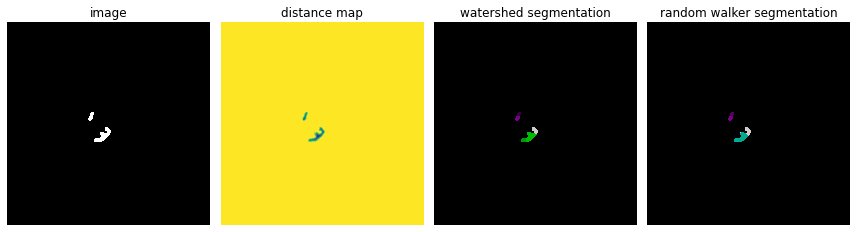

In [67]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage
import time

image = thresh
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
start = time.time()
distance = ndimage.distance_transform_edt(image)
end = time.time()
print(f'distance transform took {end - start} seconds')

In [103]:
start = time.time()
local_maxi = peak_local_max(distance, indices=False, min_distance=15, footprint=np.ones((15,15,15)), labels=image)
end = time.time()
print(f'peak local max took {end - start} seconds')

start = time.time()
markers = measure.label(local_maxi)
end = time.time()
print(f'labeling took {end - start} seconds')

start = time.time()
labels_ws = watershed(-distance, markers, mask=image)
end = time.time()
print(f'watershed took {end - start} seconds')

viewer.add_labels(labels_ws, name='watershed', blending='additive')

/var/folders/9s/nrb7wp4943vc6s4z83m51hqw0000gn/T/ipykernel_15220/1132342057.py:2: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, min_distance=15, footprint=np.ones((15,15,15)), labels=image)


peak local max took 1.8730969429016113 seconds
labeling took 1.5035357475280762 seconds
watershed took 6.279000997543335 seconds


<Labels layer 'watershed' at 0x7ff800b2ce80>

In [115]:
from skimage.segmentation import find_boundaries

def filter_boundary_labels(original_mask: np.ndarray, thresholded_labels: np.ndarray) -> np.ndarray:
    '''
    Filters the labels of the boundary of the original mask
    '''
    mask_boundaries = find_boundaries(original_mask, mode='thick').astype(np.uint8)
    boundary_coords = np.argwhere(mask_boundaries)
    label_numbers = np.unique(thresholded_labels)
    for label in tqdm(label_numbers):
        print(f'filtering label {label}')
        if label == 0:
            continue
        curr_thrsh_label = thresholded_labels == label
        curr_thrsh_boundary = find_boundaries(curr_thrsh_label, mode='thick').astype(np.uint8)
        boundary_coords_in_label = np.argwhere(curr_thrsh_boundary)
        for coord in boundary_coords_in_label:
            if coord.tolist() in boundary_coords.tolist():
                thresholded_labels[curr_thrsh_label] = 0
                break
        
    return thresholded_labels

boundary_cleaned = filter_boundary_labels(curr_mask, labels_ws)
viewer.add_labels(boundary_cleaned, name='boundary cleaned', blending='additive')






  0%|          | 0/29 [00:00<?, ?it/s]

filtering label 0
filtering label 1


  3%|▎         | 1/29 [00:33<15:36, 33.46s/it]


KeyboardInterrupt: 

In [104]:
mask_boundaries = find_boundaries(curr_mask, mode='thick').astype(np.uint8)

example_thresh_label_num = 1
exmaple_thresh_label = labels_ws == example_thresh_label_num
example_thresh_boundary = find_boundaries(exmaple_thresh_label, mode='thick').astype(np.uint8)
viewer.add_labels(mask_boundaries, name='mask boundaries', blending='additive')
viewer.add_labels(example_thresh_boundary, name='thresh boundaries', blending='additive')
boundary_coords = np.argwhere(mask_boundaries)
example_thresh_boundary_coords = np.argwhere(example_thresh_boundary)
# determine if any points in example_thresh_boundary_coords are found in boundary_coords
if np.isin(example_thresh_boundary_coords, boundary_coords).any():
    print('boundary found, removing label')
    #labels_ws[labels_ws == example_thresh_label_num] = 0
    #viewer.add_labels(labels_ws, name='watershed filtered', blending='additive')

boundary found, removing label


In [117]:
viewer.add_image(masked_tub, name = 'masked tub', blending='additive', contrast_limits=[0, 2**16])

<Image layer 'masked tub' at 0x7ff7e06e5fd0>

In [113]:
arr1 = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])
arr2 = np.array([[3,2,1],
                 [4,5,6]])

for arr in arr2:
    if arr.tolist() in arr1.tolist():
        print(f'Array {arr} found in arr1')

Array [4 5 6] found in arr1


In [121]:
from tifffile import imread, imwrite
# get labels from viewer object


#imwrite('/Users/bementmbp/Desktop/labels.tif', viewer.layers['Labels'])
viewer.layers['Labels'].save('/Users/bementmbp/Desktop/labels.tif')
viewer.layers['masked tub'].save('/Users/bementmbp/Desktop/masked_tub.tif')

['/Users/bementmbp/Desktop/masked_tub.tif']

In [78]:
viewer.add_labels(curr_mask, name='current mask', blending='additive')

<Labels layer 'current mask' at 0x7ff83456e4c0>

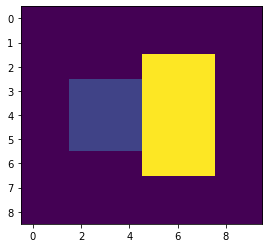

In [83]:
labels = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 5, 5, 5, 0, 0],
                   [0, 0, 1, 1, 1, 5, 5, 5, 0, 0],
                   [0, 0, 1, 1, 1, 5, 5, 5, 0, 0],
                   [0, 0, 1, 1, 1, 5, 5, 5, 0, 0],
                   [0, 0, 0, 0, 0, 5, 5, 5, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)

plt.imshow(labels)

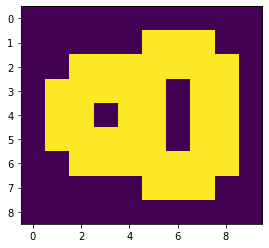

In [85]:
from skimage.segmentation import find_boundaries

plt.imshow(find_boundaries(labels, mode='thick').astype(np.uint8))

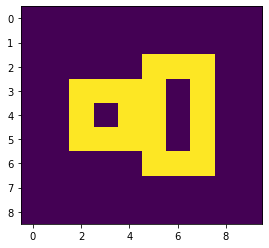

In [87]:
plt.imshow(find_boundaries(labels, mode='inner').astype(np.uint8))

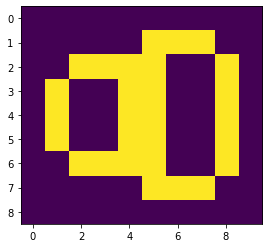

In [88]:
plt.imshow(find_boundaries(labels, mode='outer').astype(np.uint8))

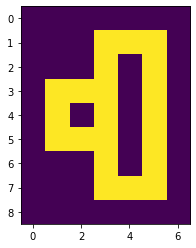

In [89]:
labels_small = labels[::2, ::3]
labels_small





plt.imshow(find_boundaries(labels_small, mode='subpixel').astype(np.uint8))

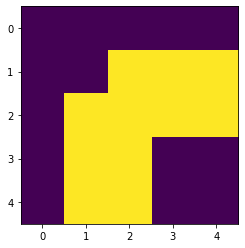

In [90]:
bool_image = np.array([[False, False, False, False, False],
                       [False, False, False, False, False],
                       [False, False,  True,  True,  True],
                       [False, False,  True,  True,  True],
                       [False, False,  True,  True,  True]],
                      dtype=bool)
plt.imshow(find_boundaries(bool_image))